In [63]:
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, LeakyReLU, Conv2D as conv2D, Dropout, Add, UpSampling2D, concatenate
import cv2
import random
import os
import PIL
from PIL import Image, ImageOps
from matplotlib import colors, cm
from ImprovedUnet import improved_unet


HEIGHT = 256
WIDTH = 256
TRAIN_SIZE = 1815
TEST_SIZE = 389
VALI_SIZE = 389

In [64]:
def dice_coef(predictions, truth, axis=(1,2,3)):
    predictions = tf.convert_to_tensor(predictions, np.float32)
    truth = tf.convert_to_tensor(truth, np.float32)
    numerator = (2.0 * (tf.reduce_sum(predictions * truth, axis=axis))) + 1
    denominator = tf.reduce_sum(predictions, axis=axis) + tf.reduce_sum(truth, axis=axis) + 1
    coef = tf.reduce_mean(numerator / denominator)
    return coef

def dice_coef_loss(predictions, truth):
    return 1 - dice_coef(predictions, truth)


def read_images(image_file, mask_file):
    img = cv2.imread(image_file)
    img = cv2.resize(img, (HEIGHT, WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = (img - img.mean())/img.std()
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (HEIGHT, WIDTH))
    mask = np.round(mask/255)
    mask = mask[:, :, np.newaxis]
    return img, mask

    
def image_generator(image_fnames, mask_fnames, batchsize):
    count = len(image_fnames)
    while True:
        random_indices = random.sample(range(count), batchsize)
        batch_img, batch_mask = [], []
        for index in random_indices:
            img, mask = read_images(image_fnames[index], mask_fnames[index])
            batch_img.append(img)
            batch_mask.append(mask)
        images = np.stack(batch_img, axis=0)
        masks = np.stack(batch_mask, axis=0)
        yield images, masks 
        
def plot_gen(data_gen):
    images, masks = next(data_gen)
    plot_images(images, 3)
    plot_images(masks, 1)

def plot_images(images, dim):
    fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,15))
    for i in range(5):
        if dim == 3:
            img = images[i, :, :, :]
            norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')  
            axs[i].imshow(img, cmap=cm.gray, norm=norm, origin="lower")
        elif dim == 1:
            img = images[i, :, :, 0]
            axs[i].imshow(img, cmap='gray')
    plt.show()
    

def check_loaded(train_gen, test_gen, val_gen):
    plot_gen(train_gen)
    plot_gen(test_gen)
    plot_gen(val_gen)
        
def plot_comparison(images, test_masks, predictions):
    images, test_masks, predictions = generate_random_images(images, test_masks, predictions)
    plot_images(images, 3)
    plot_images(test_masks, 1)    
    plot_images(predictions, 1)

def generate_random_images(test_images, test_masks, predictions):
    random_indices = random.sample(range(TEST_SIZE), 5)
    print(random_indices)
    imgs = []
    preds = []
    masks = []
    for i in random_indices:
        imgs.append(test_images[i, :, :, :])
        masks.append(test_masks[i, :, :, :])
        preds.append(predictions[i, :, :, :])
    imgs = np.stack(imgs, axis=0)
    masks = np.stack(masks, axis=0)
    preds = np.stack(preds, axis=0)
    return imgs, masks, preds

def load_images_from_fn(image_fnames, mask_fnames):
    images = []
    masks = []
    for i in range(len(image_fnames)):
        img, mask = read_images(image_fnames[i], mask_fnames[i])
        images.append(img)
        masks.append(mask)
    images = np.stack(images, axis=0)
    masks = np.stack(masks, axis=0)
    return images, masks


def load_original_test_images(test_x):
    images = []
    for file in test_x:
        img = PIL.Image.open(str(file))
        img = ImageOps.flip(img)
        img = img.resize((HEIGHT, WIDTH))
        img = np.array(img.getdata()).reshape(HEIGHT, WIDTH, 3)
        images.append(img)
    images = np.stack(images, axis=0)
    return images

def read_images(image_file, mask_file):
    img = cv2.imread(image_file)
    img = cv2.resize(img, (HEIGHT, WIDTH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = (img - img.mean())/img.std()
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (HEIGHT, WIDTH))
    mask = np.round(mask/255)
    mask = mask[:, :, np.newaxis]
    return img, mask


In [72]:
def load_data():
    input_images = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/input/*.jpg"))
    output_masks = sorted(glob.glob("H:\\COMP3710/report/ISIC2018_Task1-2_Training_Data/truth/*.png"))
    
    # Separate file names to train, validation and test.
    DATASET_SIZE = len(input_images)
    train_size = int(DATASET_SIZE * 0.7)
    val_size = test_size = int(DATASET_SIZE * 0.15)
    train_x = input_images[0:train_size]
    train_y = output_masks[0:train_size]
    test_x = input_images[train_size:train_size+test_size]
    test_y = output_masks[train_size:train_size+test_size]
    val_x = input_images[train_size+test_size:]
    val_y = output_masks[train_size+test_size:]
    
    train_gen = image_generator(train_x, train_y, 10)
    val_gen = image_generator(val_x, val_y, 10)
    test_images, test_masks = load_images_from_fn(test_x, test_y)
    test_images_forplot = load_original_test_images(test_x)
    print('Loading success')
    return train_gen, val_gen, test_masks, test_images, test_images_forplot


def compile_model(train_gen, val_gen):
    model = improved_unet(HEIGHT, WIDTH)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, 'acc'])
    # Create check point
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='acc',
        mode='max',
        save_best_only=True)
    # Compile model
    train_history = model.fit(train_gen, epochs=250, steps_per_epoch=10, validation_data = val_gen, validation_steps=10)
    return model, train_history

def plot_training_results(train_history):
    plt.plot(train_history.history['loss'], 'k', label='Training loss')
    plt.plot(train_history.history['val_loss'], 'b', label = 'Validation loss')
    plt.title('Loss of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(train_history.history['acc'], 'k', label='Training accuracy')
    plt.plot(train_history.history['val_acc'], 'b', label='Validation accuracy')
    plt.title('Accuracy of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(train_history.history['dice_coef'], 'k', label='Training dsc ')
    plt.plot(train_history.history['val_dice_coef'], 'b', label='Validation dsc')
    plt.title('Dice similarity coefficient of trained data')
    plt.xlabel('Iterations')
    plt.ylabel('Dice similarity coefficient')
    plt.legend()
    plt.grid()


Loading success
Tensor("input_3:0", shape=(None, 256, 256, 3), dtype=float32)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/250
10/10 [==============================] - 17s 2s/step - loss: 0.6796 - dice_coef: 0.2242 - acc: 0.6415 - val_loss: 0.6643 - val_dice_coef: 0.2697 - val_acc: 0.7063
Epoch 2/250
10/10 [==============================] - 13s 1s/step - loss: 0.5850 - dice_coef: 0.1672 - acc: 0.7948 - val_loss: 0.4868 - val_dice_coef: 0.2497 - val_acc: 0.7767
Epoch 3/250
10/10 [==============================] - 18s 2s/step - loss: 0.4505 - dice_coef: 0.2280 - acc: 0.8024 - val_loss: 0.4545 - val_dice_coef: 0.3276 - val_acc: 0.8052
Epoch 4/250
10/10 [==============================] - 14s 1s/step - loss: 0.3923 - dice_coef: 0.2844 - acc: 0.8493 - val_loss: 0.3889 - val_dice_coef: 0.3633 - val_acc: 0.8768
Epoch 5/250
10/10 [==============================] - 14s 1s/step - loss: 0.4305 - dice_coef: 0.2998 - acc: 0.8445 - val_loss: 0.41

Epoch 46/250
10/10 [==============================] - 16s 2s/step - loss: 0.2842 - dice_coef: 0.6064 - acc: 0.8919 - val_loss: 0.2399 - val_dice_coef: 0.6854 - val_acc: 0.9118
Epoch 47/250
10/10 [==============================] - 13s 1s/step - loss: 0.1597 - dice_coef: 0.5906 - acc: 0.9418 - val_loss: 0.1976 - val_dice_coef: 0.6707 - val_acc: 0.9258
Epoch 48/250
10/10 [==============================] - 16s 2s/step - loss: 0.2641 - dice_coef: 0.6119 - acc: 0.9039 - val_loss: 0.2077 - val_dice_coef: 0.6846 - val_acc: 0.9259
Epoch 49/250
10/10 [==============================] - 14s 1s/step - loss: 0.1990 - dice_coef: 0.6723 - acc: 0.9219 - val_loss: 0.2464 - val_dice_coef: 0.6534 - val_acc: 0.8988
Epoch 50/250
10/10 [==============================] - 15s 1s/step - loss: 0.2168 - dice_coef: 0.6177 - acc: 0.9188 - val_loss: 0.1837 - val_dice_coef: 0.6773 - val_acc: 0.9286
Epoch 51/250
10/10 [==============================] - 13s 1s/step - loss: 0.1901 - dice_coef: 0.6830 - acc: 0.9272 - val

10/10 [==============================] - 14s 1s/step - loss: 0.1201 - dice_coef: 0.7085 - acc: 0.9527 - val_loss: 0.2402 - val_dice_coef: 0.7868 - val_acc: 0.9171
Epoch 93/250
10/10 [==============================] - 16s 2s/step - loss: 0.1563 - dice_coef: 0.7105 - acc: 0.9402 - val_loss: 0.2095 - val_dice_coef: 0.7624 - val_acc: 0.9219
Epoch 94/250
10/10 [==============================] - 17s 2s/step - loss: 0.1559 - dice_coef: 0.7058 - acc: 0.9372 - val_loss: 0.2193 - val_dice_coef: 0.7293 - val_acc: 0.9133
Epoch 95/250
10/10 [==============================] - 13s 1s/step - loss: 0.1931 - dice_coef: 0.6385 - acc: 0.9241 - val_loss: 0.1777 - val_dice_coef: 0.7626 - val_acc: 0.9309
Epoch 96/250
10/10 [==============================] - 13s 1s/step - loss: 0.1538 - dice_coef: 0.7186 - acc: 0.9384 - val_loss: 0.1434 - val_dice_coef: 0.7134 - val_acc: 0.9443
Epoch 97/250
10/10 [==============================] - 14s 1s/step - loss: 0.2109 - dice_coef: 0.6744 - acc: 0.9139 - val_loss: 0.1866

10/10 [==============================] - 14s 1s/step - loss: 0.1440 - dice_coef: 0.7559 - acc: 0.9466 - val_loss: 0.1544 - val_dice_coef: 0.7882 - val_acc: 0.9420
Epoch 139/250
10/10 [==============================] - 14s 1s/step - loss: 0.1742 - dice_coef: 0.6836 - acc: 0.9320 - val_loss: 0.1812 - val_dice_coef: 0.7091 - val_acc: 0.9292
Epoch 140/250
10/10 [==============================] - 16s 2s/step - loss: 0.1891 - dice_coef: 0.6643 - acc: 0.9207 - val_loss: 0.2200 - val_dice_coef: 0.7470 - val_acc: 0.9227
Epoch 141/250
10/10 [==============================] - 15s 1s/step - loss: 0.1649 - dice_coef: 0.7213 - acc: 0.9321 - val_loss: 0.1863 - val_dice_coef: 0.7241 - val_acc: 0.9309
Epoch 142/250
10/10 [==============================] - 16s 2s/step - loss: 0.1739 - dice_coef: 0.6949 - acc: 0.9355 - val_loss: 0.2325 - val_dice_coef: 0.7437 - val_acc: 0.9107
Epoch 143/250
10/10 [==============================] - 13s 1s/step - loss: 0.1651 - dice_coef: 0.7263 - acc: 0.9375 - val_loss: 0

10/10 [==============================] - 18s 2s/step - loss: 0.1184 - dice_coef: 0.7505 - acc: 0.9525 - val_loss: 0.1644 - val_dice_coef: 0.8012 - val_acc: 0.9456
Epoch 185/250
10/10 [==============================] - 14s 1s/step - loss: 0.1298 - dice_coef: 0.7641 - acc: 0.9481 - val_loss: 0.2104 - val_dice_coef: 0.8163 - val_acc: 0.9176
Epoch 186/250
10/10 [==============================] - 13s 1s/step - loss: 0.1349 - dice_coef: 0.6874 - acc: 0.9488 - val_loss: 0.1798 - val_dice_coef: 0.7221 - val_acc: 0.9356
Epoch 187/250
10/10 [==============================] - 16s 2s/step - loss: 0.1350 - dice_coef: 0.7376 - acc: 0.9463 - val_loss: 0.1782 - val_dice_coef: 0.7832 - val_acc: 0.9344
Epoch 188/250
10/10 [==============================] - 16s 2s/step - loss: 0.1853 - dice_coef: 0.7259 - acc: 0.9237 - val_loss: 0.1879 - val_dice_coef: 0.7527 - val_acc: 0.9321
Epoch 189/250
10/10 [==============================] - 14s 1s/step - loss: 0.1515 - dice_coef: 0.6897 - acc: 0.9434 - val_loss: 0

10/10 [==============================] - 14s 1s/step - loss: 0.1258 - dice_coef: 0.7579 - acc: 0.9500 - val_loss: 0.1776 - val_dice_coef: 0.7923 - val_acc: 0.9303
Epoch 231/250
10/10 [==============================] - 16s 2s/step - loss: 0.1299 - dice_coef: 0.7395 - acc: 0.9488 - val_loss: 0.1814 - val_dice_coef: 0.7548 - val_acc: 0.9300
Epoch 232/250
10/10 [==============================] - 16s 2s/step - loss: 0.1155 - dice_coef: 0.7808 - acc: 0.9526 - val_loss: 0.1504 - val_dice_coef: 0.7894 - val_acc: 0.9410
Epoch 233/250
10/10 [==============================] - 15s 2s/step - loss: 0.1317 - dice_coef: 0.7313 - acc: 0.9480 - val_loss: 0.2111 - val_dice_coef: 0.7506 - val_acc: 0.9178
Epoch 234/250
10/10 [==============================] - 14s 1s/step - loss: 0.1440 - dice_coef: 0.7570 - acc: 0.9445 - val_loss: 0.1879 - val_dice_coef: 0.6889 - val_acc: 0.9236
Epoch 235/250
10/10 [==============================] - 12s 1s/step - loss: 0.1425 - dice_coef: 0.7329 - acc: 0.9462 - val_loss: 0

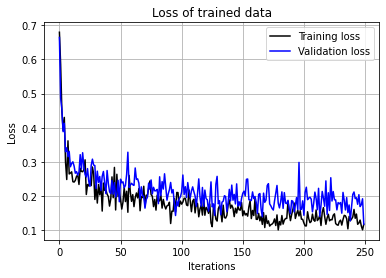

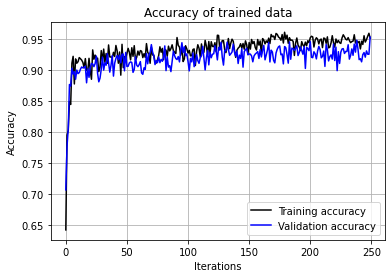

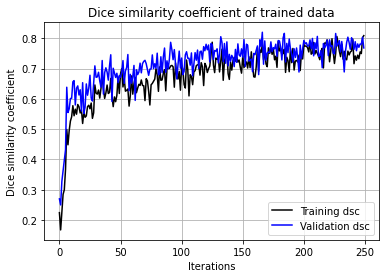

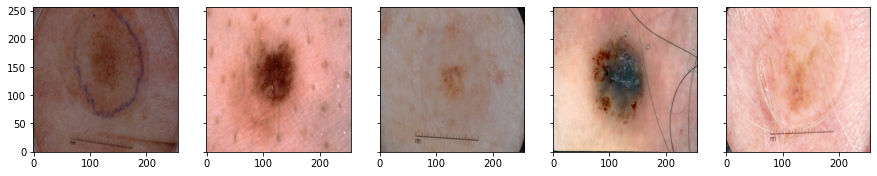

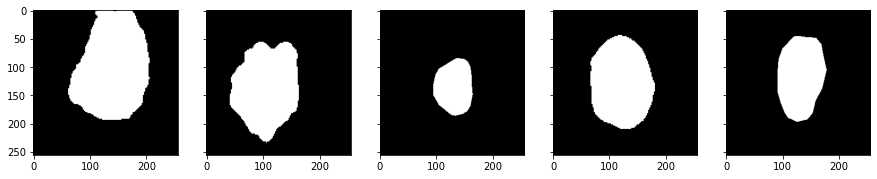

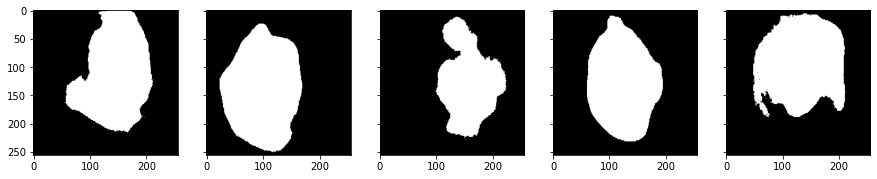

Dice similarity coefficient: 0.81319773


In [70]:
def main():
    train_gen, val_gen, test_masks, test_images, test_images_forplot = load_data()
    model, train_history = compile_model(train_gen, val_gen)
    plot_training_results(train_history)
    predictions = np.round(model.predict(test_images))
    plot_comparison(test_images_forplot, test_masks, predictions)
    dsc = dice_coef(predictions, test_masks)
    dsc = dsc.numpy()
    print('Dice similarity coefficient: ' + str(dsc))

if __name__ == "__main__":
    main()